In [36]:
# Function to generate wordclouds for each OEM
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS



In [37]:
df = pd.read_csv("car_apps_reviews.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_name     15000 non-null  object
 1   review_text  15000 non-null  object
 2   review_date  15000 non-null  object
 3   rating       15000 non-null  int64 
 4   app_version  14107 non-null  object
 5   thumbs_up    15000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 703.2+ KB


In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import math

def plot_wordclouds_grid_by_oem(df, text_col, oem_col):
    """
    Generate and display wordclouds for each OEM in a single large figure.
    """
    custom_stopwords = set(STOPWORDS).union({'app', 'car', 'work', 'vehicle', 'Ford','Tesla'})
    oems = df[oem_col].unique()
    n = len(oems)
    cols = 2  # You can change this for more/less columns
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 8, rows * 6))
    for i, oem in enumerate(oems, 1):
        text = " ".join(df[df[oem_col] == oem][text_col].astype(str))
        wc = WordCloud(width=1200, height=600, background_color='white', stopwords=custom_stopwords).generate(text)
        plt.subplot(rows, cols, i)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {oem}", fontsize=18)
    plt.tight_layout()
    plt.show()

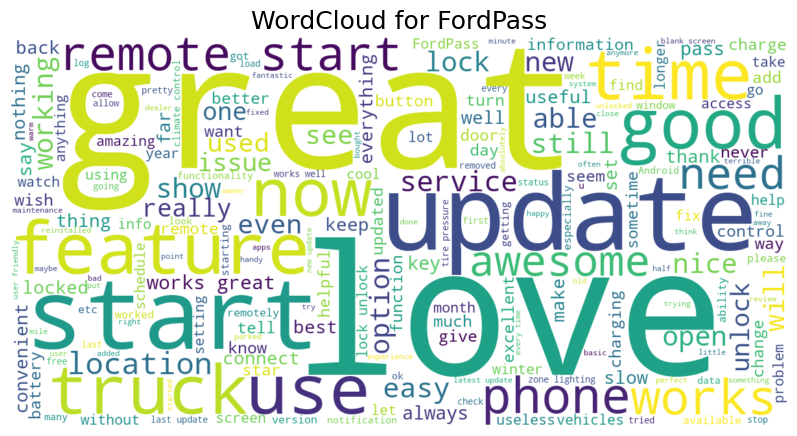

In [40]:
# Filter for Ford Pass only
ford_df = df[df['app_name'] == 'FordPass']
plot_wordclouds_grid_by_oem(ford_df, 'review_text', 'app_name')

## Topic Modeling for Ford Pass
We will use Latent Dirichlet Allocation (LDA) to extract topics from the reviews for Ford Pass.

### What is CountVectorizer?

CountVectorizer is a tool from scikit-learn that converts a collection of text documents into a matrix of token (word) counts. Each row represents a document, and each column represents a unique word from all documents. The value in each cell is the number of times that word appears in the document.


**Example:**
Suppose we have these two sentences:

1. "I love my car"
2. "I love your car"

Using CountVectorizer, we get this matrix:

|      | car | love | my | your |
|------|-----|------|----|------|
| Doc1 |  1  |  1   | 1  |  0   |
| Doc2 |  1  |  1   | 0  |  1   |

So, each document is now represented as a vector of word counts, which can be used for machine learning models.

#### What do `max_df` and `min_df` mean in CountVectorizer?

- **max_df**: This parameter ignores words that appear in more than a certain fraction of documents. For example, `max_df=0.95` means any word that appears in more than 95% of documents will be ignored. This helps remove very common words that are unlikely to be useful (like "the", "and").

- **min_df**: This parameter ignores words that appear in fewer than a certain number (or fraction) of documents. For example, `min_df=2` means any word that appears in fewer than 2 documents will be ignored. This helps remove rare words that may be typos or not useful for analysis.


These parameters help focus the analysis on words that are neither too common nor too rare.

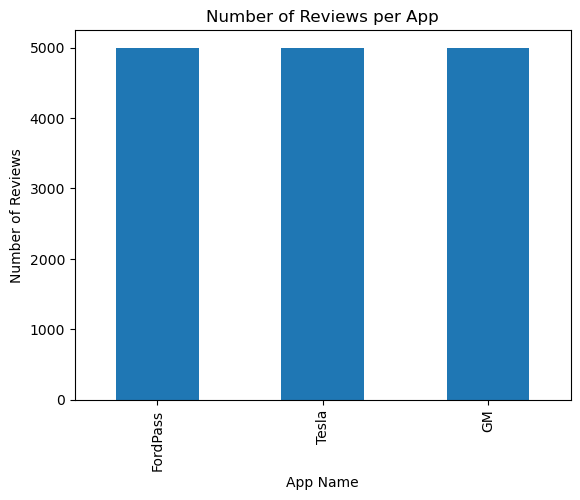

In [41]:
df['app_name'].value_counts().plot(kind='bar',xlabel='App Name', ylabel='Number of Reviews', title='Number of Reviews per App')
plt.show()

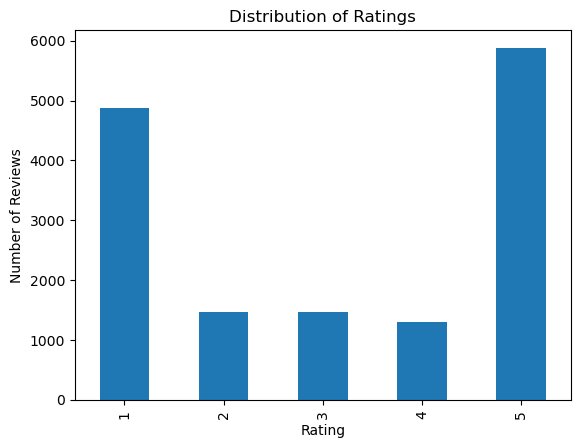

In [42]:
df['rating'].value_counts().sort_index().plot(kind='bar',xlabel='Rating', ylabel='Number of Reviews', title='Distribution of Ratings')
plt.show()

/var/folders/ys/rh_m_lvd12bc1py05dbf4g5m0000gn/T/ipykernel_56048/164534812.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()


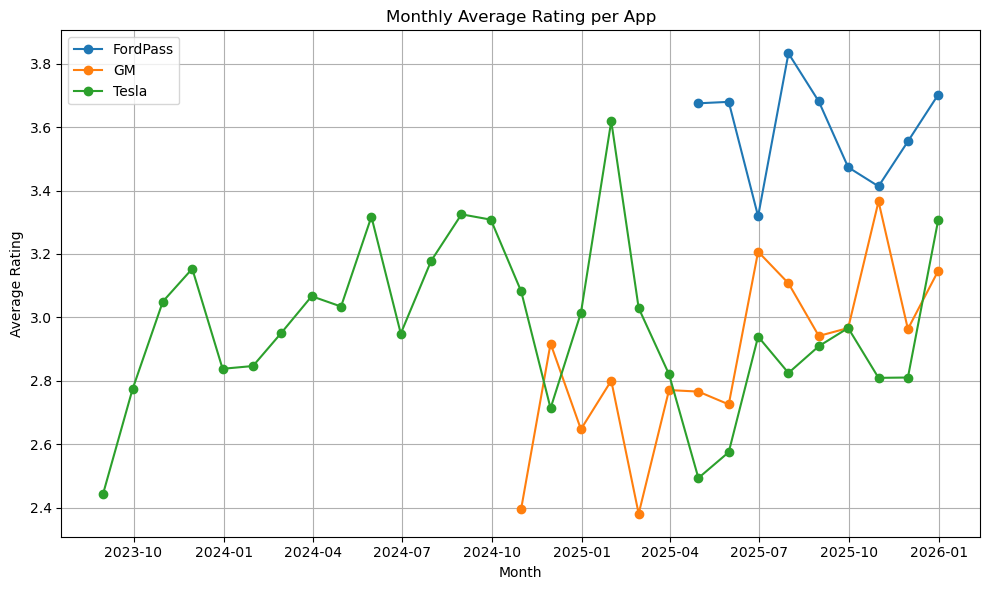

In [43]:
# Monthly average rating per app (line plot)
df['review_date'] = pd.to_datetime(df.get('review_date', df.get('at')), errors='coerce')
monthly = df.dropna(subset=['review_date']).groupby([pd.Grouper(key='review_date', freq='M'), 'app_name'])['rating'].mean().reset_index()
pivot = monthly.pivot(index='review_date', columns='app_name', values='rating')
plt.figure(figsize=(10,6))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.title('Monthly Average Rating per App')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

def print_all_words_with_weights(model, feature_names):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        for i in topic.argsort()[::-1]:
            print(f"{feature_names[i]}: {topic[i]:.4f}")

def lda_topic_modeling(df, text_col, n_topics=3, n_top_words=10, show_all_weights=False):
    texts = df[text_col].astype(str).values
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(texts)
    if X.shape[0] < n_topics:
        print("Not enough documents for topic modeling.")
        return None, None, None
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words)
    if show_all_weights:
        print_all_words_with_weights(lda, vectorizer.get_feature_names_out())
    return lda, vectorizer, X

# Example usage:
lda, vectorizer, X = lda_topic_modeling(ford_df, 'review_text', n_topics=3, n_top_words=10, show_all_weights=True)

Topic #1:
app great start works car update vehicle remote time work

Topic #2:
love app ford good great use easy service car pass

Topic #3:
app like awesome vehicle truck update features just work ford


Topic #1:
app: 1318.5429
great: 505.9952
start: 502.8702
works: 461.3496
car: 369.0682
update: 338.1441
vehicle: 282.3477
remote: 281.2110
time: 273.4746
work: 272.2582
doesn: 255.9111
working: 203.8489
just: 174.4569
phone: 172.3521
ford: 169.7154
won: 143.2528
unlock: 124.4543
lock: 124.3855
open: 115.8905
location: 111.4159
use: 102.3200
battery: 97.7669
nice: 96.4957
says: 89.9420
screen: 89.5161
new: 83.6952
times: 79.1759
don: 76.5651
worked: 76.5203
like: 75.2130
used: 74.8673
need: 73.9007
issues: 71.8994
useless: 68.3445
ve: 67.1498
connect: 64.9468
does: 63.6514
tried: 60.2945
fix: 59.6657
watch: 58.4754
keeps: 56.7215
blank: 55.3197
issue: 54.1194
auto: 52.1350
let: 51.6876
charging: 49.7600
charge: 48.0591
updates: 46.0821
log: 46.0665
want: 45.3793
stopped: 45.1555
days: 

In [35]:
# Check number of reviews for Ford Pass and preview some text
print(f"Number of Ford Pass reviews: {len(ford_df)}")
print(ford_df['review_text'].head(3))

Number of Ford Pass reviews: 5000
0    locations struggles to update and is currently...
1                          love the Ford pass feature.
2                                          works great
Name: review_text, dtype: object
